# Installations and Imports

In [15]:
!pip install tf-keras-vis
!pip install tensorflow-addons

# Imports

import os
import time
import numpy as np
import shutil
import random
import zipfile
from imutils import paths

import tensorflow as tf
# import tensorflow_hub as hub
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.applications import MobileNetV2, ResNet50, VGG16, InceptionV3, Xception
from tensorflow.keras.layers import AveragePooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

%reload_ext autoreload
%autoreload 2
# from tf_keras_vis.utils.scores import BinaryScore
# from tf_keras_vis.saliency import Saliency
# from tf_keras_vis.gradcam import Gradcam
# from tf_keras_vis.gradcam_plus_plus import GradcamPlusPlus
# from tf_keras_vis.scorecam import Scorecam

%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from tensorflow.data import AUTOTUNE
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import train_test_split

# Create train, validation and test data generators

In [2]:
#@title function to create resnet50

from gc import callbacks

def model_resnet50():
  IMG_SIZE = (224,224)
  IMG_SHAPE = IMG_SIZE + (3,)

  preprocess_input = tf.keras.applications.resnet50.preprocess_input

  inputs = tf.keras.Input(shape=(IMG_SHAPE))
  x = preprocess_input(inputs)

  base_model = ResNet50(input_shape=(IMG_SHAPE),
                          include_top=False,
                          weights='imagenet',
                        input_tensor=x)

  # base_model.trainable = False
  base_model.trainable = True

  if base_model.trainable:
      # Let's take a look to see how many layers are in the base model
    print("Number of layers in the base model: ", len(base_model.layers))

    # Fine-tune from this layer onwards
    fine_tune_at = 175
    
    number_frozen = 0

    # Freeze all the layers before the `fine_tune_at` layer
    for layer in base_model.layers[:fine_tune_at]:
      layer.trainable = False
      number_frozen = number_frozen + 1

    # Un-freeze the BatchNorm layers
    for layer in base_model.layers:
      if "BatchNormalization" in layer.__class__.__name__:
          layer.trainable = True
          number_frozen = number_frozen - 1

    print(str(number_frozen) + " layers were frozen")
    print(str(len(base_model.layers) - number_frozen) + " layers to fine-tune")



  # inputs = tf.keras.Input(shape=(IMG_SHAPE))
  # x = preprocess_input(inputs)
  # x = base_model(x, training=base_model.trainable)
  # x = tf.keras.layers.AveragePooling2D()(base_model.output)
  x = tf.keras.layers.Flatten()(base_model.output)
  x = tf.keras.layers.Dropout(0.5)(x)
  # x = tf.keras.layers.Dense(2048, activation="relu")(x)
  x = tf.keras.layers.Dense(100, activation="relu")(x)
  # x = tf.keras.layers.Dropout(0.5)(x)
  x = tf.keras.layers.Dense(32, activation="relu")(x)
  # x = tf.keras.layers.Dense(256, activation="relu")(x)
  outputs = tf.keras.layers.Dense(2, activation="softmax")(x)

  model = tf.keras.Model(base_model.input, outputs)


  base_learning_rate = 0.0003
  #import tensorflow_addons as tfa
  opt = tf.optimizers.Adam(learning_rate=base_learning_rate, decay=base_learning_rate/50)


  model.compile(optimizer=opt,
                loss='categorical_crossentropy',
                metrics=['accuracy'])
  # model.compile(optimizer='SGD',
  #               loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
  #               metrics=['accuracy'])
  
  return model

In [3]:
#@title Function to create MobileNet

from gc import callbacks

def model_mobilenetv2():
  IMG_SIZE = (224,224)
  IMG_SHAPE = IMG_SIZE + (3,)

  preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

  inputs = tf.keras.Input(shape=(IMG_SHAPE))
  x = preprocess_input(inputs)
  
  base_model = MobileNetV2(input_shape=(IMG_SHAPE),
                         include_top=False,
                         weights='imagenet',
                         input_tensor=x)

  # base_model.trainable = False
  base_model.trainable = True

  if base_model.trainable:
      # Let's take a look to see how many layers are in the base model
    print("Number of layers in the base model: ", len(base_model.layers))

    # Fine-tune from this layer onwards
    fine_tune_at = 100
    
    number_frozen = 0

    # Freeze all the layers before the `fine_tune_at` layer
    for layer in base_model.layers[:fine_tune_at]:
      layer.trainable = False
      number_frozen = number_frozen + 1

    # Un-freeze the BatchNorm layers
    for layer in base_model.layers:
      if "BatchNormalization" in layer.__class__.__name__:
          layer.trainable = True
          number_frozen = number_frozen - 1

    print(str(number_frozen) + " layers were frozen")
    print(str(len(base_model.layers) - number_frozen) + " layers to fine-tune")



  # inputs = tf.keras.Input(shape=(IMG_SHAPE))
  # x = preprocess_input(inputs)
  # x = base_model(x, training=base_model.trainable)
  # x = tf.keras.layers.AveragePooling2D()(base_model.output)
  x = tf.keras.layers.Flatten()(base_model.output)
  x = tf.keras.layers.Dropout(0.5)(x)
  # x = tf.keras.layers.Dense(2048, activation="relu")(x)
  x = tf.keras.layers.Dense(100, activation="relu")(x)
  # x = tf.keras.layers.Dropout(0.5)(x)
  x = tf.keras.layers.Dense(32, activation="relu")(x)
  # x = tf.keras.layers.Dense(256, activation="relu")(x)
  outputs = tf.keras.layers.Dense(2, activation="softmax")(x)

  model = tf.keras.Model(base_model.input, outputs)


  base_learning_rate = 0.0003
  #import tensorflow_addons as tfa
  opt = tf.optimizers.Adam(learning_rate=base_learning_rate, decay=base_learning_rate/50)


  model.compile(optimizer=opt,
                loss='categorical_crossentropy',
                metrics=['accuracy'])
  # model.compile(optimizer='SGD',
  #               loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
  #               metrics=['accuracy'])
  
  return model

In [4]:
#@title function to create vgg16

from gc import callbacks

def model_vgg16():
  IMG_SIZE = (224,224)
  IMG_SHAPE = IMG_SIZE + (3,)

  preprocess_input = tf.keras.applications.vgg16.preprocess_input

  inputs = tf.keras.Input(shape=(IMG_SHAPE))
  x = preprocess_input(inputs)

  base_model = VGG16(input_shape=(IMG_SHAPE),
                          include_top=False,
                          weights='imagenet',
                        input_tensor=x)

  # base_model.trainable = False
  base_model.trainable = True

  if base_model.trainable:
      # Let's take a look to see how many layers are in the base model
    print("Number of layers in the base model: ", len(base_model.layers))

    # Fine-tune from this layer onwards
    fine_tune_at = -1
    
    number_frozen = 0

    # Freeze all the layers before the `fine_tune_at` layer
    for layer in base_model.layers[:fine_tune_at]:
      layer.trainable = False
      number_frozen = number_frozen + 1

    # Un-freeze the BatchNorm layers
    for layer in base_model.layers:
      if "BatchNormalization" in layer.__class__.__name__:
          layer.trainable = True
          number_frozen = number_frozen - 1

    print(str(number_frozen) + " layers were frozen")
    print(str(len(base_model.layers) - number_frozen) + " layers to fine-tune")



  # inputs = tf.keras.Input(shape=(IMG_SHAPE))
  # x = preprocess_input(inputs)
  # x = base_model(x, training=base_model.trainable)
  # x = tf.keras.layers.AveragePooling2D()(base_model.output)
  x = tf.keras.layers.Flatten()(base_model.output)
  x = tf.keras.layers.Dropout(0.5)(x)
  # x = tf.keras.layers.Dense(2048, activation="relu")(x)
  x = tf.keras.layers.Dense(100, activation="relu")(x)
  # x = tf.keras.layers.Dropout(0.5)(x)
  x = tf.keras.layers.Dense(32, activation="relu")(x)
  # x = tf.keras.layers.Dense(256, activation="relu")(x)
  outputs = tf.keras.layers.Dense(2, activation="softmax")(x)

  model = tf.keras.Model(base_model.input, outputs)


  base_learning_rate = 0.0003
  #import tensorflow_addons as tfa
  opt = tf.optimizers.Adam(learning_rate=base_learning_rate, decay=base_learning_rate/50)


  model.compile(optimizer=opt,
                loss='categorical_crossentropy',
                metrics=['accuracy'])
  # model.compile(optimizer='SGD',
  #               loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
  #               metrics=['accuracy'])
  
  return model

In [5]:
#@title function to create inceptionv3

from gc import callbacks

def model_inceptionv3():
  IMG_SIZE = (224,224)
  IMG_SHAPE = IMG_SIZE + (3,)

  preprocess_input = tf.keras.applications.inception_v3.preprocess_input

  inputs = tf.keras.Input(shape=(IMG_SHAPE))
  x = preprocess_input(inputs)

  base_model = InceptionV3(input_shape=(IMG_SHAPE),
                          include_top=False,
                          weights='imagenet',
                        input_tensor=x)

  # base_model.trainable = False
  base_model.trainable = True

  if base_model.trainable:
      # Let's take a look to see how many layers are in the base model
    print("Number of layers in the base model: ", len(base_model.layers))

    # Fine-tune from this layer onwards
    fine_tune_at = -1
    
    number_frozen = 0

    # Freeze all the layers before the `fine_tune_at` layer
    for layer in base_model.layers[:fine_tune_at]:
      layer.trainable = False
      number_frozen = number_frozen + 1

    # Un-freeze the BatchNorm layers
    for layer in base_model.layers:
      if "BatchNormalization" in layer.__class__.__name__:
          layer.trainable = True
          number_frozen = number_frozen - 1

    print(str(number_frozen) + " layers were frozen")
    print(str(len(base_model.layers) - number_frozen) + " layers to fine-tune")



  # inputs = tf.keras.Input(shape=(IMG_SHAPE))
  # x = preprocess_input(inputs)
  # x = base_model(x, training=base_model.trainable)
  # x = tf.keras.layers.AveragePooling2D()(base_model.output)
  x = tf.keras.layers.Flatten()(base_model.output)
  x = tf.keras.layers.Dropout(0.5)(x)
  # x = tf.keras.layers.Dense(2048, activation="relu")(x)
  x = tf.keras.layers.Dense(100, activation="relu")(x)
  # x = tf.keras.layers.Dropout(0.5)(x)
  x = tf.keras.layers.Dense(32, activation="relu")(x)
  # x = tf.keras.layers.Dense(256, activation="relu")(x)
  outputs = tf.keras.layers.Dense(2, activation="softmax")(x)

  model = tf.keras.Model(base_model.input, outputs)


  base_learning_rate = 0.0003
  #import tensorflow_addons as tfa
  opt = tf.optimizers.Adam(learning_rate=base_learning_rate, decay=base_learning_rate/50)


  model.compile(optimizer=opt,
                loss='categorical_crossentropy',
                metrics=['accuracy'])
  # model.compile(optimizer='SGD',
  #               loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
  #               metrics=['accuracy'])
  
  return model

In [6]:
#@title function to create xception

from gc import callbacks

def model_xception():
  IMG_SIZE = (224,224)
  IMG_SHAPE = IMG_SIZE + (3,)

  preprocess_input = tf.keras.applications.xception.preprocess_input

  inputs = tf.keras.Input(shape=(IMG_SHAPE))
  x = preprocess_input(inputs)

  base_model = Xception(input_shape=(IMG_SHAPE),
                          include_top=False,
                          weights='imagenet',
                        input_tensor=x)

  # base_model.trainable = False
  base_model.trainable = True

  if base_model.trainable:
      # Let's take a look to see how many layers are in the base model
    print("Number of layers in the base model: ", len(base_model.layers))

    # Fine-tune from this layer onwards
    fine_tune_at = -1
    
    number_frozen = 0

    # Freeze all the layers before the `fine_tune_at` layer
    for layer in base_model.layers[:fine_tune_at]:
      layer.trainable = False
      number_frozen = number_frozen + 1

    # Un-freeze the BatchNorm layers
    for layer in base_model.layers:
      if "BatchNormalization" in layer.__class__.__name__:
          layer.trainable = True
          number_frozen = number_frozen - 1

    print(str(number_frozen) + " layers were frozen")
    print(str(len(base_model.layers) - number_frozen) + " layers to fine-tune")



  # inputs = tf.keras.Input(shape=(IMG_SHAPE))
  # x = preprocess_input(inputs)
  # x = base_model(x, training=base_model.trainable)
  # x = tf.keras.layers.AveragePooling2D()(base_model.output)
  x = tf.keras.layers.Flatten()(base_model.output)
  x = tf.keras.layers.Dropout(0.5)(x)
  # x = tf.keras.layers.Dense(2048, activation="relu")(x)
  x = tf.keras.layers.Dense(100, activation="relu")(x)
  # x = tf.keras.layers.Dropout(0.5)(x)
  x = tf.keras.layers.Dense(32, activation="relu")(x)
  # x = tf.keras.layers.Dense(256, activation="relu")(x)
  outputs = tf.keras.layers.Dense(2, activation="softmax")(x)

  model = tf.keras.Model(base_model.input, outputs)


  base_learning_rate = 0.0003
  #import tensorflow_addons as tfa
  opt = tf.optimizers.Adam(learning_rate=base_learning_rate, decay=base_learning_rate/50)


  model.compile(optimizer=opt,
                loss='categorical_crossentropy',
                metrics=['accuracy'])
  # model.compile(optimizer='SGD',
  #               loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
  #               metrics=['accuracy'])
  
  return model

In [7]:
# from google.colab import drive
# drive.mount('/content/drive/')

# %cd '/content/drive/MyDrive/Colab Notebooks/Mestrado/bancos/'
# %ls

In [8]:
imagePaths = list(paths.list_images('./sars-cov-2/0_non-COVID/')) + list(paths.list_images('./sars-cov-2/COVID/'))
imagePaths = list(paths.list_images('/home/pedro/sars-cov-2-binary-dataset/0_non-COVID')) + list(paths.list_images('/home/pedro/sars-cov-2-binary-dataset/COVID'))

# Training the models

In [33]:
# Generator for kfold
def get_model_name(k):
    return 'model_'+str(k)+'.h5'

def load_images(imagePath):
	# read the image from disk, decode it, resize it, and scale the
	# pixels intensities to the range [0, 1]
	image = tf.io.read_file(imagePath)
	image = tf.image.decode_png(image, channels=3)
	image = tf.image.resize(image, (224, 224))
	# grab the label and encode it
	label = tf.strings.split(imagePath, os.path.sep)[-2]
	oneHot = label == classNames
	encodedLabel = tf.argmax(oneHot)
	# return the image and the integer encoded label
	return (image, oneHot)
 
def augment_using_ops(images, labels):
  images = tf.image.random_flip_left_right(images)
  return (images, labels)
 
IMG_SIZE = (224,224) 
 # initialize batch size and number of steps
BATCH_SIZE = 4
# grab the list of images in our dataset directory and grab all
# unique class names
EPOCHS = 10

#print("[INFO] loading image paths...")
#imagePaths = list(paths.list_images('./sars-cov-2/0_non-COVID/')) + list(paths.list_images('./sars-cov-2/COVID/'))
imagePaths = list(paths.list_images('/home/pedro/sars-cov-2-binary-dataset/0_non-COVID')) + list(paths.list_images('/home/pedro/sars-cov-2-binary-dataset/COVID'))
imagePaths = np.array(imagePaths)
imagePaths_train, imagePaths_test = train_test_split(imagePaths, test_size=0.2, random_state=42)
classNames = ['0_non-COVID', 'COVID']

kf = KFold(n_splits = 5)
i = 1                       
VALIDATION_ACCURACY = {'resnet50':[], 'mobilenetv2':[], 'vgg16':[], 'inceptionv3':[], 'xception':[]}
VALIDAITON_LOSS = {'resnet50':[], 'mobilenetv2':[], 'vgg16':[], 'inceptionv3':[], 'xception':[]}

TEST_ACCURACY = {'resnet50':[], 'mobilenetv2':[], 'vgg16':[], 'inceptionv3':[], 'xception':[]}
TEST_LOSS = {'resnet50':[], 'mobilenetv2':[], 'vgg16':[], 'inceptionv3':[], 'xception':[]}

for train_index, val_index in kf.split(imagePaths_train):
  print("=========================================")
  print(f"====== K Fold Validation step => {i}/5 =======")
  print("=========================================")
  trainData = imagePaths_train[train_index]
  valData = imagePaths_train[val_index]

  # build the dataset and data input pipeline
  print("[INFO] creating a tf.data input pipeline..")
  dataset_train = tf.data.Dataset.from_tensor_slices(trainData)
  dataset_train = (dataset_train
    .shuffle(1024)
    .map(load_images, num_parallel_calls=AUTOTUNE)
    .cache()
    .repeat()
    .batch(BATCH_SIZE)
    .map(augment_using_ops, num_parallel_calls=AUTOTUNE)
    .prefetch(AUTOTUNE)
  )

  datasetGen_train = iter(dataset_train)

  dataset_val = tf.data.Dataset.from_tensor_slices(valData)
  dataset_val = (dataset_val
    .shuffle(1024)
    .map(load_images, num_parallel_calls=AUTOTUNE)
    .cache()
    .repeat()
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
  )

  datasetGen_val = iter(dataset_val)

  dataset_test = tf.data.Dataset.from_tensor_slices(imagePaths_test)
  dataset_test = (dataset_test
    .shuffle(1024)
    .map(load_images, num_parallel_calls=AUTOTUNE)
    .cache()
    .repeat()
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
  )

  datasetGen_test = iter(dataset_test) 

  training_images = len(trainData)
  val_images = len(valData)

  STEPS_PER_EPOCH = training_images // BATCH_SIZE
  VALIDATION_STEPS = val_images // BATCH_SIZE

  ### Xception

  model = model_xception()

  save_dir = './models/xception/'
  checkpoint = tf.keras.callbacks.ModelCheckpoint(save_dir+get_model_name(i), 
							monitor='val_accuracy', verbose=1, 
							save_best_only=True, mode='max')
  callbacks_list = [checkpoint]

  print('\n---------- Training xception ----------')

  history = model.fit(
        datasetGen_train,
        steps_per_epoch=STEPS_PER_EPOCH,  
        epochs=EPOCHS,
        verbose=0,
        callbacks=callbacks_list,
        validation_data = datasetGen_val,
        validation_steps=VALIDATION_STEPS)
  
  model.load_weights("./models/xception/model_"+str(i)+".h5")
  
  results_val = model.evaluate(datasetGen_val, steps=VALIDATION_STEPS, verbose=0)
  results_val = dict(zip(model.metrics_names,results_val))

  results_test = model.evaluate(datasetGen_test, steps=len(imagePaths_test), verbose=0)
  results_test = dict(zip(model.metrics_names,results_test))

  VALIDATION_ACCURACY['xception'].append(results_val['accuracy'])
  VALIDAITON_LOSS['xception'].append(results_val['accuracy'])

  TEST_ACCURACY['xception'].append(results_test['accuracy'])
  TEST_LOSS['xception'].append(results_test['accuracy'])

  tf.keras.backend.clear_session()

  ### InceptionV3

  model = model_inceptionv3()

  save_dir = './models/inceptionv3/'
  checkpoint = tf.keras.callbacks.ModelCheckpoint(save_dir+get_model_name(i), 
							monitor='val_accuracy', verbose=1, 
							save_best_only=True, mode='max')
  callbacks_list = [checkpoint]

  print('\n---------- Training inceptionv3 ----------')

  history = model.fit(
        datasetGen_train,
        steps_per_epoch=STEPS_PER_EPOCH,  
        epochs=EPOCHS,
        verbose=0,
        callbacks=callbacks_list,
        validation_data = datasetGen_val,
        validation_steps=VALIDATION_STEPS)
  
  model.load_weights("./models/inceptionv3/model_"+str(i)+".h5")
  
  results_val = model.evaluate(datasetGen_val, steps=VALIDATION_STEPS, verbose=0)
  results_val = dict(zip(model.metrics_names,results_val))

  results_test = model.evaluate(datasetGen_test, steps=len(imagePaths_test), verbose=0)
  results_test = dict(zip(model.metrics_names,results_test))

  VALIDATION_ACCURACY['inceptionv3'].append(results_val['accuracy'])
  VALIDAITON_LOSS['inceptionv3'].append(results_val['accuracy'])

  TEST_ACCURACY['inceptionv3'].append(results_test['accuracy'])
  TEST_LOSS['inceptionv3'].append(results_test['accuracy'])

  tf.keras.backend.clear_session()

  ### VGG16

  model = model_vgg16()

  save_dir = './models/vgg16/'
  checkpoint = tf.keras.callbacks.ModelCheckpoint(save_dir+get_model_name(i), 
							monitor='val_accuracy', verbose=1, 
							save_best_only=True, mode='max')
  callbacks_list = [checkpoint]

  print('\n---------- Training vgg16 ----------')

  history = model.fit(
        datasetGen_train,
        steps_per_epoch=STEPS_PER_EPOCH,  
        epochs=EPOCHS,
        verbose=0,
        callbacks=callbacks_list,
        validation_data = datasetGen_val,
        validation_steps=VALIDATION_STEPS)
  
  model.load_weights("./models/vgg16/model_"+str(i)+".h5")
  
  results_val = model.evaluate(datasetGen_val, steps=VALIDATION_STEPS, verbose=0)
  results_val = dict(zip(model.metrics_names,results_val))

  results_test = model.evaluate(datasetGen_test, steps=len(imagePaths_test), verbose=0)
  results_test = dict(zip(model.metrics_names,results_test))

  VALIDATION_ACCURACY['vgg16'].append(results_val['accuracy'])
  VALIDAITON_LOSS['vgg16'].append(results_val['accuracy'])

  TEST_ACCURACY['vgg16'].append(results_test['accuracy'])
  TEST_LOSS['vgg16'].append(results_test['accuracy'])

  tf.keras.backend.clear_session()

  ### ResNet50

  model = model_resnet50()

  save_dir = './models/resnet50/'
  checkpoint = tf.keras.callbacks.ModelCheckpoint(save_dir+get_model_name(i), 
							monitor='val_accuracy', verbose=1, 
							save_best_only=True, mode='max')
  callbacks_list = [checkpoint]

  print('\n---------- Training ResNet50 ----------')

  history = model.fit(
        datasetGen_train,
        steps_per_epoch=STEPS_PER_EPOCH,  
        epochs=EPOCHS,
        verbose=0,
        callbacks=callbacks_list,
        validation_data = datasetGen_val,
        validation_steps=VALIDATION_STEPS)
  
  model.load_weights("./models/resnet50/model_"+str(i)+".h5")
  
  results_val = model.evaluate(datasetGen_val, steps=VALIDATION_STEPS, verbose=0)
  results_val = dict(zip(model.metrics_names,results_val))

  results_test = model.evaluate(datasetGen_test, steps=len(imagePaths_test), verbose=0)
  results_test = dict(zip(model.metrics_names,results_test))

  VALIDATION_ACCURACY['resnet50'].append(results_val['accuracy'])
  VALIDAITON_LOSS['resnet50'].append(results_val['accuracy'])

  TEST_ACCURACY['resnet50'].append(results_test['accuracy'])
  TEST_LOSS['resnet50'].append(results_test['accuracy'])

  tf.keras.backend.clear_session()


  ### MobileNet
  model = model_mobilenetv2()

  save_dir = './models/mobilenetv2/'
  checkpoint = tf.keras.callbacks.ModelCheckpoint(save_dir+get_model_name(i), 
							monitor='val_accuracy', verbose=1, 
							save_best_only=True, mode='max')
  callbacks_list = [checkpoint]

  print('\n---------- Training MobileNetV2 ----------')

  history = model.fit(
        datasetGen_train,
        steps_per_epoch=STEPS_PER_EPOCH,  
        epochs=EPOCHS,
        verbose=0,
        callbacks=callbacks_list,
        validation_data = datasetGen_val,
        validation_steps=VALIDATION_STEPS)
  
  model.load_weights("./models/mobilenetv2/model_"+str(i)+".h5")
  
  results_val = model.evaluate(datasetGen_val, steps=VALIDATION_STEPS, verbose=0)
  results_val = dict(zip(model.metrics_names,results_val))

  results_test = model.evaluate(datasetGen_test, steps=len(imagePaths_test), verbose=0)
  results_test = dict(zip(model.metrics_names,results_test))

  VALIDATION_ACCURACY['mobilenetv2'].append(results_val['accuracy'])
  VALIDAITON_LOSS['mobilenetv2'].append(results_val['accuracy'])

  TEST_ACCURACY['mobilenetv2'].append(results_test['accuracy'])
  TEST_LOSS['mobilenetv2'].append(results_test['accuracy'])

  tf.keras.backend.clear_session()

  



  i = i+1

#print(VALIDATION_ACCURACY)

====== K Fold Validation step => 1/5 =======
[INFO] creating a tf.data input pipeline..
Number of layers in the base model:  134
93 layers were frozen
41 layers to fine-tune

---------- Training xception ----------

Epoch 1: val_accuracy improved from -inf to 0.78030, saving model to ./models/xception/model_1.h5

Epoch 2: val_accuracy improved from 0.78030 to 0.89141, saving model to ./models/xception/model_1.h5

Epoch 3: val_accuracy improved from 0.89141 to 0.91162, saving model to ./models/xception/model_1.h5

Epoch 4: val_accuracy improved from 0.91162 to 0.92929, saving model to ./models/xception/model_1.h5

Epoch 5: val_accuracy improved from 0.92929 to 0.93434, saving model to ./models/xception/model_1.h5

Epoch 6: val_accuracy did not improve from 0.93434

Epoch 7: val_accuracy improved from 0.93434 to 0.94697, saving model to ./models/xception/model_1.h5

Epoch 8: val_accuracy improved from 0.94697 to 0.94949, saving model to ./models/xception/model_1.h5

Epoch 9: val_accuracy

Number of layers in the base model:  156
48 layers were frozen
108 layers to fine-tune

---------- Training MobileNetV2 ----------

Epoch 1: val_accuracy improved from -inf to 0.62879, saving model to ./models/mobilenetv2/model_2.h5

Epoch 2: val_accuracy did not improve from 0.62879

Epoch 3: val_accuracy improved from 0.62879 to 0.90657, saving model to ./models/mobilenetv2/model_2.h5

Epoch 4: val_accuracy did not improve from 0.90657

Epoch 5: val_accuracy did not improve from 0.90657

Epoch 6: val_accuracy did not improve from 0.90657

Epoch 7: val_accuracy did not improve from 0.90657

Epoch 8: val_accuracy improved from 0.90657 to 0.93939, saving model to ./models/mobilenetv2/model_2.h5

Epoch 9: val_accuracy did not improve from 0.93939

Epoch 10: val_accuracy did not improve from 0.93939
====== K Fold Validation step => 3/5 =======
[INFO] creating a tf.data input pipeline..
Number of layers in the base model:  134
93 layers were frozen
41 layers to fine-tune

---------- Traini


Epoch 8: val_accuracy improved from 0.95707 to 0.95960, saving model to ./models/vgg16/model_4.h5

Epoch 9: val_accuracy improved from 0.95960 to 0.96717, saving model to ./models/vgg16/model_4.h5

Epoch 10: val_accuracy improved from 0.96717 to 0.97727, saving model to ./models/vgg16/model_4.h5
Number of layers in the base model:  177
122 layers were frozen
55 layers to fine-tune

---------- Training ResNet50 ----------

Epoch 1: val_accuracy improved from -inf to 0.77525, saving model to ./models/resnet50/model_4.h5

Epoch 2: val_accuracy improved from 0.77525 to 0.92677, saving model to ./models/resnet50/model_4.h5

Epoch 3: val_accuracy improved from 0.92677 to 0.94192, saving model to ./models/resnet50/model_4.h5

Epoch 4: val_accuracy improved from 0.94192 to 0.94949, saving model to ./models/resnet50/model_4.h5

Epoch 5: val_accuracy did not improve from 0.94949

Epoch 6: val_accuracy did not improve from 0.94949

Epoch 7: val_accuracy did not improve from 0.94949

Epoch 8: val

# ResNet50 Results

In [34]:
# Load images and Convert them to a Numpy array
imgs = []
labels = []
i = 0

for img in imagePaths_test:
  label = img.split('/')[-2]
  img = load_img(img, target_size=(224, 224))
  imgs.append(np.array(img))

  
  if label == 'COVID':
    labels.append([0, 1.0])
    i = i + 1
  else:
    labels.append([1.0, 0])
 
testX = np.asarray(imgs)

testY = np.array(labels)
#preprocess_input = tf.keras.applications.resnet50.preprocess_input
#testX = preprocess_input(images)
print(np.shape(testX))

(497, 224, 224, 3)


In [35]:
### ResNet50
model = model_resnet50()
model.load_weights("./models/resnet50/model_"+str(np.argmax(TEST_ACCURACY["resnet50"])+1)+".h5")
results_test = model.evaluate(datasetGen_test, steps=len(imagePaths_test))
results_test = dict(zip(model.metrics_names,results_test))
print(results_test['accuracy'])

Number of layers in the base model:  177
122 layers were frozen
55 layers to fine-tune
497/497 [==============================] - 8s 15ms/step - loss: 0.1196 - accuracy: 0.9638
0.9637826681137085


[INFO] evaluating network...
497/497 [==============================] - 5s 8ms/step
              precision    recall  f1-score   support

   non covid       0.96      0.95      0.95       238
       covid       0.95      0.97      0.96       259

    accuracy                           0.96       497
   macro avg       0.96      0.96      0.96       497
weighted avg       0.96      0.96      0.96       497

[[225  13]
 [  9 250]]
acc: 0.9557
sensitivity: 0.9454
specificity: 0.9653


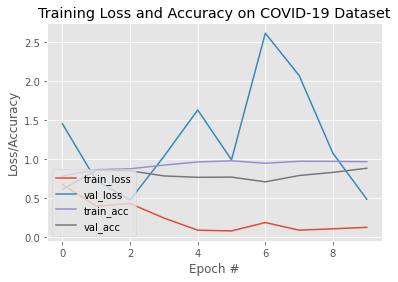

In [36]:
### ResNet50
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=1)

#print(predIdxs)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

#testY = np.array([[0, 1.0], [0, 1.0], [1.0, 0]])

# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=['non covid', 'covid']))

# vp fp
# fn vn 

# compute the confusion matrix and and use it to derive the raw
# accuracy, sensitivity, and specificity
cm = confusion_matrix(testY.argmax(axis=1), predIdxs)
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])

# show the confusion matrix, accuracy, sensitivity, and specificity
print(cm)
print("acc: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on COVID-19 Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

In [55]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

accuracies = []
precisions = []
recalls = []
f1s = []
sensitivities = []
specificities = []

resnet_path = '/home/pedro/Master/models/resnet50'
for model_path in os.listdir(resnet_path):
    model = model_resnet50()
    model.load_weights(os.path.join(resnet_path, model_path))
    predIdxs = model.predict(testX, batch_size=1, verbose=0)
    predIdxs = np.argmax(predIdxs, axis=1)
    
    acc = accuracy_score(testY.argmax(axis=1), predIdxs)
    prec = precision_score(testY.argmax(axis=1), predIdxs)
    rec = recall_score(testY.argmax(axis=1), predIdxs)
    f1 = f1_score(testY.argmax(axis=1), predIdxs)
    
    cm = confusion_matrix(testY.argmax(axis=1), predIdxs)
    total = sum(sum(cm))
    
    sen = cm[0, 0] / (cm[0, 0] + cm[0, 1])
    spec = cm[1, 1] / (cm[1, 0] + cm[1, 1])
    
    accuracies.append(acc)
    precisions.append(prec)
    recalls.append(rec)
    f1s.append(f1)
    sensitivities.append(sen)
    specificities.append(spec)

print('======= ResNet50 5-fold Final Results =======\n')
print(f'Accuracy: {round(np.mean(accuracies),3)} \u00B1 {round(np.std(accuracies),3)}')
print(f'Precision: {round(np.mean(precisions),3)} \u00B1 {round(np.std(precisions),3)}')
print(f'Recall: {round(np.mean(recalls),3)} \u00B1 {round(np.std(recalls),3)}')
print(f'F1-Score: {round(np.mean(f1s),3)} \u00B1 {round(np.std(f1s),3)}')
print(f'Sensitivity: {round(np.mean(sensitivities),3)} \u00B1 {round(np.std(sensitivities),3)}')
print(f'Specificity: {round(np.mean(specificities),3)} \u00B1 {round(np.std(specificities),3)}')

Number of layers in the base model:  177
122 layers were frozen
55 layers to fine-tune
497/497 [==============================] - 5s 8ms/step
Number of layers in the base model:  177
122 layers were frozen
55 layers to fine-tune
497/497 [==============================] - 4s 8ms/step
Number of layers in the base model:  177
122 layers were frozen
55 layers to fine-tune
497/497 [==============================] - 5s 8ms/step
Number of layers in the base model:  177
122 layers were frozen
55 layers to fine-tune
497/497 [==============================] - 5s 8ms/step
Number of layers in the base model:  177
122 layers were frozen
55 layers to fine-tune
497/497 [==============================] - 5s 8ms/step


# MobileNetV2 Results

In [37]:
### MobileNetV2
model = model_mobilenetv2()
model.load_weights("./models/mobilenetv2/model_"+str(np.argmax(TEST_ACCURACY["mobilenetv2"])+1)+".h5")
results_test = model.evaluate(datasetGen_test, steps=len(imagePaths_test))
results_test = dict(zip(model.metrics_names,results_test))
print(results_test['accuracy'])

Number of layers in the base model:  156
48 layers were frozen
108 layers to fine-tune
497/497 [==============================] - 5s 7ms/step - loss: 0.1945 - accuracy: 0.9296
0.9295774698257446


[INFO] evaluating network...
497/497 [==============================] - 3s 6ms/step
              precision    recall  f1-score   support

   non covid       0.92      0.94      0.93       238
       covid       0.94      0.92      0.93       259

    accuracy                           0.93       497
   macro avg       0.93      0.93      0.93       497
weighted avg       0.93      0.93      0.93       497

[[223  15]
 [ 20 239]]
acc: 0.9296
sensitivity: 0.9370
specificity: 0.9228


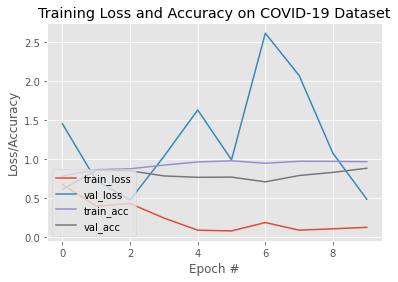

In [38]:
### MobileNetV2
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=1)

#print(predIdxs)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

#testY = np.array([[0, 1.0], [0, 1.0], [1.0, 0]])

# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=['non covid', 'covid']))

# vp fp
# fn vn 

# compute the confusion matrix and and use it to derive the raw
# accuracy, sensitivity, and specificity
cm = confusion_matrix(testY.argmax(axis=1), predIdxs)
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])

# show the confusion matrix, accuracy, sensitivity, and specificity
print(cm)
print("acc: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on COVID-19 Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

In [62]:
accuracies = []
precisions = []
recalls = []
f1s = []
sensitivities = []
specificities = []

resnet_path = '/home/pedro/Master/models/mobilenetv2'
for model_path in os.listdir(resnet_path):
    model = model_mobilenetv2()
    model.load_weights(os.path.join(resnet_path, model_path))
    predIdxs = model.predict(testX, batch_size=1, verbose=0)
    predIdxs = np.argmax(predIdxs, axis=1)
    
    acc = accuracy_score(testY.argmax(axis=1), predIdxs)
    prec = precision_score(testY.argmax(axis=1), predIdxs)
    rec = recall_score(testY.argmax(axis=1), predIdxs)
    f1 = f1_score(testY.argmax(axis=1), predIdxs)
    
    cm = confusion_matrix(testY.argmax(axis=1), predIdxs)
    total = sum(sum(cm))
    
    sen = cm[0, 0] / (cm[0, 0] + cm[0, 1])
    spec = cm[1, 1] / (cm[1, 0] + cm[1, 1])
    
    accuracies.append(acc)
    precisions.append(prec)
    recalls.append(rec)
    f1s.append(f1)
    sensitivities.append(sen)
    specificities.append(spec)

print('======= MobileNetV2 5-fold Final Results =======\n')
print(f'Accuracy: {round(np.mean(accuracies),3)} \u00B1 {round(np.std(accuracies),3)}')
print(f'Precision: {round(np.mean(precisions),3)} \u00B1 {round(np.std(precisions),3)}')
print(f'Recall: {round(np.mean(recalls),3)} \u00B1 {round(np.std(recalls),3)}')
print(f'F1-Score: {round(np.mean(f1s),3)} \u00B1 {round(np.std(f1s),3)}')
print(f'Sensitivity: {round(np.mean(sensitivities),3)} \u00B1 {round(np.std(sensitivities),3)}')
print(f'Specificity: {round(np.mean(specificities),3)} \u00B1 {round(np.std(specificities),3)}')

Number of layers in the base model:  156
48 layers were frozen
108 layers to fine-tune
Number of layers in the base model:  156
48 layers were frozen
108 layers to fine-tune
Number of layers in the base model:  156
48 layers were frozen
108 layers to fine-tune
Number of layers in the base model:  156
48 layers were frozen
108 layers to fine-tune
Number of layers in the base model:  156
48 layers were frozen
108 layers to fine-tune
======= MobileNetV2 5-fold Final Results =======

Accuracy: 0.898 ± 0.019
Precision: 0.898 ± 0.045
Recall: 0.914 ± 0.064
F1-Score: 0.902 ± 0.021
Sensitivity: 0.881 ± 0.059
Specificity: 0.914 ± 0.064


# VGG16 Results

In [39]:
### VGG16
model = model_vgg16()
model.load_weights("./models/vgg16/model_"+str(np.argmax(TEST_ACCURACY["vgg16"])+1)+".h5")
results_test = model.evaluate(datasetGen_test, steps=len(imagePaths_test))
results_test = dict(zip(model.metrics_names,results_test))
print(results_test['accuracy'])

Number of layers in the base model:  21
20 layers were frozen
1 layers to fine-tune
497/497 [==============================] - 11s 22ms/step - loss: 0.0500 - accuracy: 0.9819
0.9818913340568542


[INFO] evaluating network...
497/497 [==============================] - 3s 7ms/step
              precision    recall  f1-score   support

   non covid       0.99      0.96      0.97       238
       covid       0.96      0.99      0.98       259

    accuracy                           0.97       497
   macro avg       0.97      0.97      0.97       497
weighted avg       0.97      0.97      0.97       497

[[228  10]
 [  3 256]]
acc: 0.9738
sensitivity: 0.9580
specificity: 0.9884


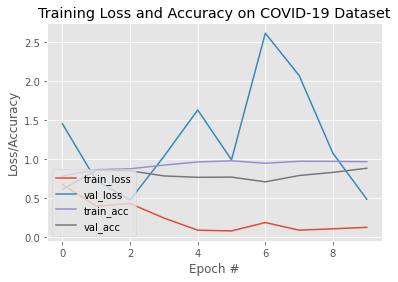

In [40]:
### VGG16
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=1)

#print(predIdxs)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

#testY = np.array([[0, 1.0], [0, 1.0], [1.0, 0]])

# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=['non covid', 'covid']))

# vp fp
# fn vn 

# compute the confusion matrix and and use it to derive the raw
# accuracy, sensitivity, and specificity
cm = confusion_matrix(testY.argmax(axis=1), predIdxs)
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])

# show the confusion matrix, accuracy, sensitivity, and specificity
print(cm)
print("acc: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on COVID-19 Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

In [64]:
accuracies = []
precisions = []
recalls = []
f1s = []
sensitivities = []
specificities = []

resnet_path = '/home/pedro/Master/models/vgg16'
for model_path in os.listdir(resnet_path):
    model = model_vgg16()
    model.load_weights(os.path.join(resnet_path, model_path))
    predIdxs = model.predict(testX, batch_size=1, verbose=0)
    predIdxs = np.argmax(predIdxs, axis=1)
    
    acc = accuracy_score(testY.argmax(axis=1), predIdxs)
    prec = precision_score(testY.argmax(axis=1), predIdxs)
    rec = recall_score(testY.argmax(axis=1), predIdxs)
    f1 = f1_score(testY.argmax(axis=1), predIdxs)
    
    cm = confusion_matrix(testY.argmax(axis=1), predIdxs)
    total = sum(sum(cm))
    
    sen = cm[0, 0] / (cm[0, 0] + cm[0, 1])
    spec = cm[1, 1] / (cm[1, 0] + cm[1, 1])
    
    accuracies.append(acc)
    precisions.append(prec)
    recalls.append(rec)
    f1s.append(f1)
    sensitivities.append(sen)
    specificities.append(spec)

print('======= VGG16 5-fold Final Results =======\n')
print(f'Accuracy: {round(np.mean(accuracies),3)} \u00B1 {round(np.std(accuracies),3)}')
print(f'Precision: {round(np.mean(precisions),3)} \u00B1 {round(np.std(precisions),3)}')
print(f'Recall: {round(np.mean(recalls),3)} \u00B1 {round(np.std(recalls),3)}')
print(f'F1-Score: {round(np.mean(f1s),3)} \u00B1 {round(np.std(f1s),3)}')
print(f'Sensitivity: {round(np.mean(sensitivities),3)} \u00B1 {round(np.std(sensitivities),3)}')
print(f'Specificity: {round(np.mean(specificities),3)} \u00B1 {round(np.std(specificities),3)}')

Number of layers in the base model:  21
20 layers were frozen
1 layers to fine-tune
Number of layers in the base model:  21
20 layers were frozen
1 layers to fine-tune
Number of layers in the base model:  21
20 layers were frozen
1 layers to fine-tune
Number of layers in the base model:  21
20 layers were frozen
1 layers to fine-tune
Number of layers in the base model:  21
20 layers were frozen
1 layers to fine-tune
======= VGG16 5-fold Final Results =======

Accuracy: 0.955 ± 0.014
Precision: 0.959 ± 0.023
Recall: 0.956 ± 0.039
F1-Score: 0.957 ± 0.015
Sensitivity: 0.955 ± 0.027
Specificity: 0.956 ± 0.039


# InceptionV3 Results

In [41]:
### InceptionV3
model = model_inceptionv3()
model.load_weights("./models/inceptionv3/model_"+str(np.argmax(TEST_ACCURACY["inceptionv3"])+1)+".h5")
results_test = model.evaluate(datasetGen_test, steps=len(imagePaths_test))
results_test = dict(zip(model.metrics_names,results_test))
print(results_test['accuracy'])

Number of layers in the base model:  313
218 layers were frozen
95 layers to fine-tune
497/497 [==============================] - 9s 15ms/step - loss: 0.3877 - accuracy: 0.8652
0.8651911616325378


[INFO] evaluating network...
497/497 [==============================] - 6s 10ms/step
              precision    recall  f1-score   support

   non covid       0.81      0.84      0.82       238
       covid       0.84      0.81      0.83       259

    accuracy                           0.82       497
   macro avg       0.82      0.83      0.82       497
weighted avg       0.83      0.82      0.83       497

[[199  39]
 [ 48 211]]
acc: 0.8249
sensitivity: 0.8361
specificity: 0.8147


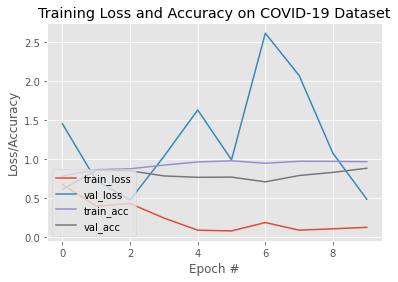

In [42]:
### InceptionV3
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=1)

#print(predIdxs)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

#testY = np.array([[0, 1.0], [0, 1.0], [1.0, 0]])

# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=['non covid', 'covid']))

# vp fp
# fn vn 

# compute the confusion matrix and and use it to derive the raw
# accuracy, sensitivity, and specificity
cm = confusion_matrix(testY.argmax(axis=1), predIdxs)
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])

# show the confusion matrix, accuracy, sensitivity, and specificity
print(cm)
print("acc: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on COVID-19 Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

In [65]:
accuracies = []
precisions = []
recalls = []
f1s = []
sensitivities = []
specificities = []

resnet_path = '/home/pedro/Master/models/inceptionv3'
for model_path in os.listdir(resnet_path):
    model = model_inceptionv3()
    model.load_weights(os.path.join(resnet_path, model_path))
    predIdxs = model.predict(testX, batch_size=1, verbose=0)
    predIdxs = np.argmax(predIdxs, axis=1)
    
    acc = accuracy_score(testY.argmax(axis=1), predIdxs)
    prec = precision_score(testY.argmax(axis=1), predIdxs)
    rec = recall_score(testY.argmax(axis=1), predIdxs)
    f1 = f1_score(testY.argmax(axis=1), predIdxs)
    
    cm = confusion_matrix(testY.argmax(axis=1), predIdxs)
    total = sum(sum(cm))
    
    sen = cm[0, 0] / (cm[0, 0] + cm[0, 1])
    spec = cm[1, 1] / (cm[1, 0] + cm[1, 1])
    
    accuracies.append(acc)
    precisions.append(prec)
    recalls.append(rec)
    f1s.append(f1)
    sensitivities.append(sen)
    specificities.append(spec)

print('======= InceptionV3 5-fold Final Results =======\n')
print(f'Accuracy: {round(np.mean(accuracies),3)} \u00B1 {round(np.std(accuracies),3)}')
print(f'Precision: {round(np.mean(precisions),3)} \u00B1 {round(np.std(precisions),3)}')
print(f'Recall: {round(np.mean(recalls),3)} \u00B1 {round(np.std(recalls),3)}')
print(f'F1-Score: {round(np.mean(f1s),3)} \u00B1 {round(np.std(f1s),3)}')
print(f'Sensitivity: {round(np.mean(sensitivities),3)} \u00B1 {round(np.std(sensitivities),3)}')
print(f'Specificity: {round(np.mean(specificities),3)} \u00B1 {round(np.std(specificities),3)}')

Number of layers in the base model:  313
218 layers were frozen
95 layers to fine-tune
Number of layers in the base model:  313
218 layers were frozen
95 layers to fine-tune
Number of layers in the base model:  313
218 layers were frozen
95 layers to fine-tune
Number of layers in the base model:  313
218 layers were frozen
95 layers to fine-tune
Number of layers in the base model:  313
218 layers were frozen
95 layers to fine-tune
======= InceptionV3 5-fold Final Results =======

Accuracy: 0.829 ± 0.013
Precision: 0.86 ± 0.029
Recall: 0.807 ± 0.058
F1-Score: 0.83 ± 0.02
Sensitivity: 0.854 ± 0.046
Specificity: 0.807 ± 0.058


# Xception Results

In [43]:
### Xception
model = model_xception()
model.load_weights("./models/xception/model_"+str(np.argmax(TEST_ACCURACY["xception"])+1)+".h5")
results_test = model.evaluate(datasetGen_test, steps=len(imagePaths_test))
results_test = dict(zip(model.metrics_names,results_test))
print(results_test['accuracy'])

Number of layers in the base model:  134
93 layers were frozen
41 layers to fine-tune
497/497 [==============================] - 9s 16ms/step - loss: 0.3327 - accuracy: 0.9074
0.9074446558952332


[INFO] evaluating network...
497/497 [==============================] - 4s 7ms/step
              precision    recall  f1-score   support

   non covid       0.89      0.93      0.91       238
       covid       0.93      0.90      0.92       259

    accuracy                           0.91       497
   macro avg       0.91      0.91      0.91       497
weighted avg       0.91      0.91      0.91       497

[[221  17]
 [ 26 233]]
acc: 0.9135
sensitivity: 0.9286
specificity: 0.8996


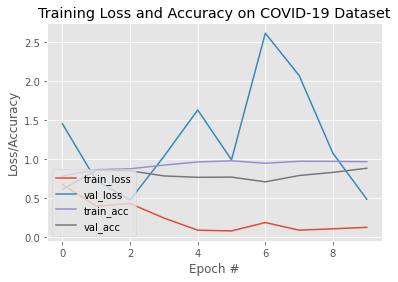

In [44]:
### Xception
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=1)

#print(predIdxs)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

#testY = np.array([[0, 1.0], [0, 1.0], [1.0, 0]])

# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=['non covid', 'covid']))

# vp fp
# fn vn 

# compute the confusion matrix and and use it to derive the raw
# accuracy, sensitivity, and specificity
cm = confusion_matrix(testY.argmax(axis=1), predIdxs)
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])

# show the confusion matrix, accuracy, sensitivity, and specificity
print(cm)
print("acc: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on COVID-19 Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

In [66]:
accuracies = []
precisions = []
recalls = []
f1s = []
sensitivities = []
specificities = []

resnet_path = '/home/pedro/Master/models/xception'
for model_path in os.listdir(resnet_path):
    model = model_xception()
    model.load_weights(os.path.join(resnet_path, model_path))
    predIdxs = model.predict(testX, batch_size=1, verbose=0)
    predIdxs = np.argmax(predIdxs, axis=1)
    
    acc = accuracy_score(testY.argmax(axis=1), predIdxs)
    prec = precision_score(testY.argmax(axis=1), predIdxs)
    rec = recall_score(testY.argmax(axis=1), predIdxs)
    f1 = f1_score(testY.argmax(axis=1), predIdxs)
    
    cm = confusion_matrix(testY.argmax(axis=1), predIdxs)
    total = sum(sum(cm))
    
    sen = cm[0, 0] / (cm[0, 0] + cm[0, 1])
    spec = cm[1, 1] / (cm[1, 0] + cm[1, 1])
    
    accuracies.append(acc)
    precisions.append(prec)
    recalls.append(rec)
    f1s.append(f1)
    sensitivities.append(sen)
    specificities.append(spec)

print('======= Xception 5-fold Final Results =======\n')
print(f'Accuracy: {round(np.mean(accuracies),3)} \u00B1 {round(np.std(accuracies),3)}')
print(f'Precision: {round(np.mean(precisions),3)} \u00B1 {round(np.std(precisions),3)}')
print(f'Recall: {round(np.mean(recalls),3)} \u00B1 {round(np.std(recalls),3)}')
print(f'F1-Score: {round(np.mean(f1s),3)} \u00B1 {round(np.std(f1s),3)}')
print(f'Sensitivity: {round(np.mean(sensitivities),3)} \u00B1 {round(np.std(sensitivities),3)}')
print(f'Specificity: {round(np.mean(specificities),3)} \u00B1 {round(np.std(specificities),3)}')

Number of layers in the base model:  134
93 layers were frozen
41 layers to fine-tune
Number of layers in the base model:  134
93 layers were frozen
41 layers to fine-tune
Number of layers in the base model:  134
93 layers were frozen
41 layers to fine-tune
Number of layers in the base model:  134
93 layers were frozen
41 layers to fine-tune
Number of layers in the base model:  134
93 layers were frozen
41 layers to fine-tune
======= Xception 5-fold Final Results =======

Accuracy: 0.9 ± 0.011
Precision: 0.912 ± 0.025
Recall: 0.895 ± 0.015
F1-Score: 0.903 ± 0.009
Sensitivity: 0.905 ± 0.032
Specificity: 0.895 ± 0.015


# Ensemble Results - Integrated Stacking Model

In [11]:
# https://machinelearningmastery.com/stacking-ensemble-for-deep-learning-neural-networks/

resnet50 = model_resnet50()
resnet50.load_weights("./models/resnet50/model_5.h5")
#resnet50.load_weights("./models/resnet50/model_"+str(np.argmax(TEST_ACCURACY["resnet50"])+1)+".h5")

mobilenetv2 = model_mobilenetv2()
mobilenetv2.load_weights("./models/mobilenetv2/model_5.h5")
#mobilenetv2.load_weights("./models/mobilenetv2/model_"+str(np.argmax(TEST_ACCURACY["mobilenetv2"])+1)+".h5")

vgg16 = model_vgg16()
vgg16.load_weights("./models/vgg16/model_5.h5")
#vgg16.load_weights("./models/vgg16/model_"+str(np.argmax(TEST_ACCURACY["vgg16"])+1)+".h5")

inceptionv3 = model_inceptionv3()
inceptionv3.load_weights("./models/inceptionv3/model_5.h5")
#inceptionv3.load_weights("./models/inceptionv3/model_"+str(np.argmax(TEST_ACCURACY["inceptionv3"])+1)+".h5")

xception = model_xception()
xception.load_weights("./models/xception/model_5.h5")
#xception.load_weights("./models/xception/model_"+str(np.argmax(TEST_ACCURACY["xception"])+1)+".h5")

members = [resnet50, mobilenetv2, vgg16, inceptionv3, xception]


Number of layers in the base model:  177
122 layers were frozen
55 layers to fine-tune
Number of layers in the base model:  156
48 layers were frozen
108 layers to fine-tune
Number of layers in the base model:  21
20 layers were frozen
1 layers to fine-tune
Number of layers in the base model:  313
218 layers were frozen
95 layers to fine-tune
Number of layers in the base model:  134
93 layers were frozen
41 layers to fine-tune


In [12]:
#from keras.layers.merge import concatenate
from keras.layers import concatenate
from tensorflow.keras.utils import plot_model
from keras.models import Model

# define stacked model from multiple member input models
def define_stacked_model(members):
	# update all layers in all models to not be trainable
	for i in range(len(members)):
		model = members[i]
		for layer in model.layers:
			# make not trainable
			layer.trainable = False
			# rename to avoid 'unique layer name' issue
			layer._name = 'ensemble_' + str(i+1) + '_' + layer.name
	# define multi-headed input
	ensemble_visible = [model.input for model in members]
	# concatenate merge output from each model
	ensemble_outputs = [model.output for model in members]
	merge = concatenate(ensemble_outputs)
	hidden = Dense(10, activation='relu')(merge)
	output = Dense(2, activation='softmax')(hidden)
	model = Model(inputs=ensemble_visible, outputs=output)
	# plot graph of ensemble
	#plot_model(model, show_shapes=True, to_file='model_graph.png')
	# compile
	model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
	return model

In [13]:
stacked_model = define_stacked_model(members)

In [ ]:
# Load images and Convert them to a Numpy array
imgs = []
labels = []
i = 0

for img in imagePaths_train:
  label = img.split('/')[-2]
  img = load_img(img, target_size=(224, 224))
  imgs.append(np.array(img))

  
  if label == 'COVID':
    labels.append([0, 1.0])
    i = i + 1
  else:
    labels.append([1.0, 0])
 
trainX = np.asarray(imgs)

trainY = np.array(labels)

# Load images and Convert them to a Numpy array
imgs = []
labels = []
i = 0

for img in imagePaths_test:
  label = img.split('/')[-2]
  img = load_img(img, target_size=(224, 224))
  imgs.append(np.array(img))

  
  if label == 'COVID':
    labels.append([0, 1.0])
    i = i + 1
  else:
    labels.append([1.0, 0])
 
testX = np.asarray(imgs)

testY = np.array(labels)

In [71]:
X = [trainX for _ in range(len(stacked_model.input))]

history = stacked_model.fit(X, trainY, epochs=5, verbose=1)

Epoch 1/5
62/62 [==============================] - 28s 329ms/step - loss: 0.8735 - accuracy: 0.5131
Epoch 2/5
24/62 [==========>...................] - ETA: 12s - loss: 0.4980 - accuracy: 0.6016

KeyboardInterrupt: 

In [ ]:
X = [testX for _ in range(len(stacked_model.input))]

### Ensemble
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = stacked_model.predict(X, verbose=0)

#print(predIdxs)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

#testY = np.array([[0, 1.0], [0, 1.0], [1.0, 0]])

# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=['non covid', 'covid']))

# vp fp
# fn vn 

# compute the confusion matrix and and use it to derive the raw
# accuracy, sensitivity, and specificity
cm = confusion_matrix(testY.argmax(axis=1), predIdxs)
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])

# show the confusion matrix, accuracy, sensitivity, and specificity
print(cm)
print("acc: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on COVID-19 Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

In [ ]:
# imagePaths = list(paths.list_images('/home/pedro/sars-cov-2-binary-dataset/0_non-COVID')) + list(paths.list_images('/home/pedro/sars-cov-2-binary-dataset/COVID'))
# imagePaths = np.array(imagePaths)

# kf = KFold(n_splits = 5)
# j = 1                       
# VALIDATION_ACCURACY = []
# VALIDAITON_LOSS = []

# TEST_ACCURACY = []
# TEST_LOSS = []

# for train_index, val_index in kf.split(imagePaths):
#     print("=========================================")
#     print(f"====== K Fold Validation step => {j}/5 =======")
#     print("=========================================")
#     trainData = imagePaths[train_index]
#     testData = imagePaths[val_index]
    
#     stacked_model = define_stacked_model(members)

#     # Load images and Convert them to a Numpy array
#     imgs = []
#     labels = []
#     i = 0

#     for img in trainData:
#       label = img.split('/')[-2]
#       img = load_img(img, target_size=(224, 224))
#       imgs.append(np.array(img))


#       if label == 'COVID':
#         labels.append([0, 1.0])
#         i = i + 1
#       else:
#         labels.append([1.0, 0])

#     trainX = np.asarray(imgs)

#     trainY = np.array(labels)

#     # Load images and Convert them to a Numpy array
#     imgs = []
#     labels = []
#     i = 0

#     for img in testData:
#       label = img.split('/')[-2]
#       img = load_img(img, target_size=(224, 224))
#       imgs.append(np.array(img))


#       if label == 'COVID':
#         labels.append([0, 1.0])
#         i = i + 1
#       else:
#         labels.append([1.0, 0])

#     testX = np.asarray(imgs)

#     testY = np.array(labels)
    
#     X = [trainX for _ in range(len(stacked_model.input))]

#     save_dir = './models/ensemble/'
#     checkpoint = tf.keras.callbacks.ModelCheckpoint(save_dir+'model_' + str(j) + '.h5' , 
#             monitor='accuracy', verbose=1, 
#             save_best_only=True, mode='max')
#     callbacks_list = [checkpoint]
    
#     history = stacked_model.fit(X, trainY, epochs=1, verbose=1, callbacks=callbacks_list)
    
#     X = [testX for _ in range(len(stacked_model.input))]
    
#     stacked_model.load_weights("./models/ensemble/model_"+str(j)+".h5")
    
#     j = j+1
    
#     results_test = stacked_model.evaluate(X, testY, verbose=0)
#     results_test = dict(zip(stacked_model.metrics_names,results_test))

#     TEST_ACCURACY.append(results_test['accuracy'])
#     TEST_LOSS.append(results_test['accuracy'])

#     tf.keras.backend.clear_session()   